# Balanced allocations

In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from lib import compute_gap, \
                one_choice, two_choice, beta_choice,\
                partial_information_k1, partial_information_k2

SAVE_FIGS=False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gap for different strategies considering $d$-batch

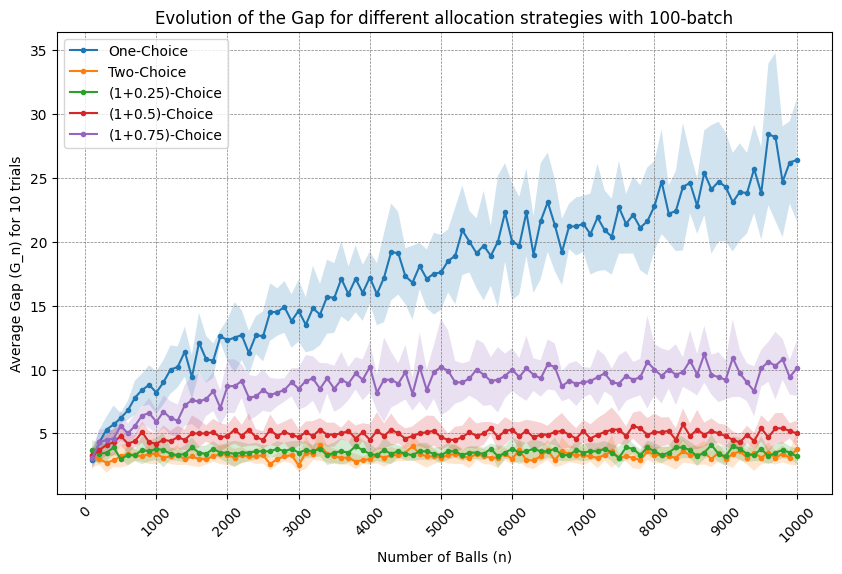

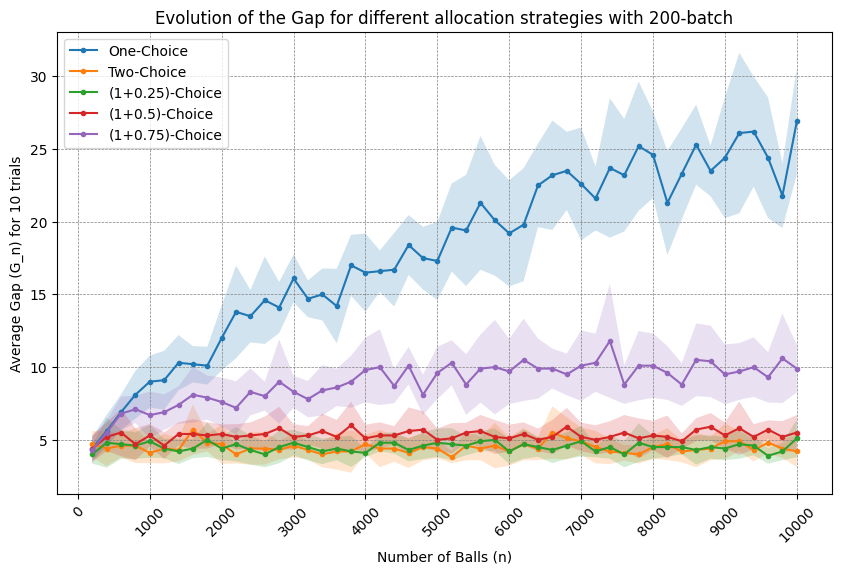

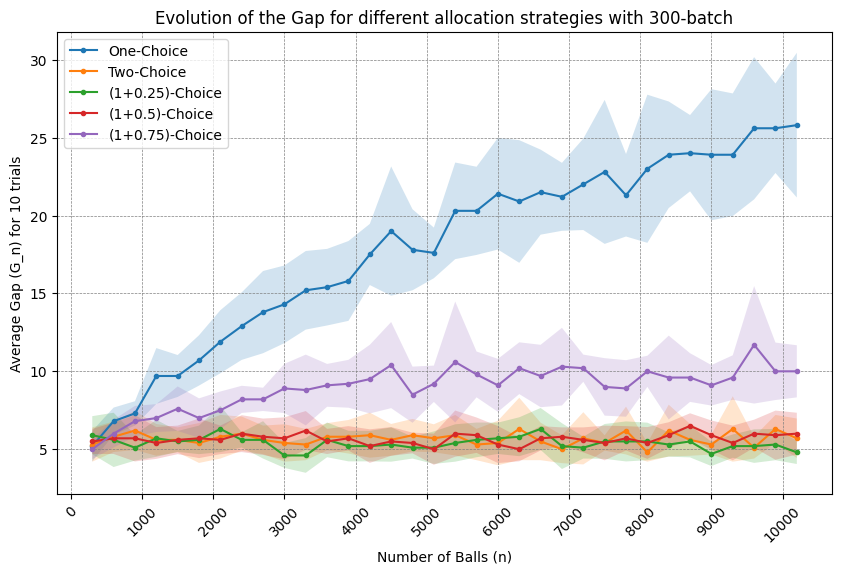

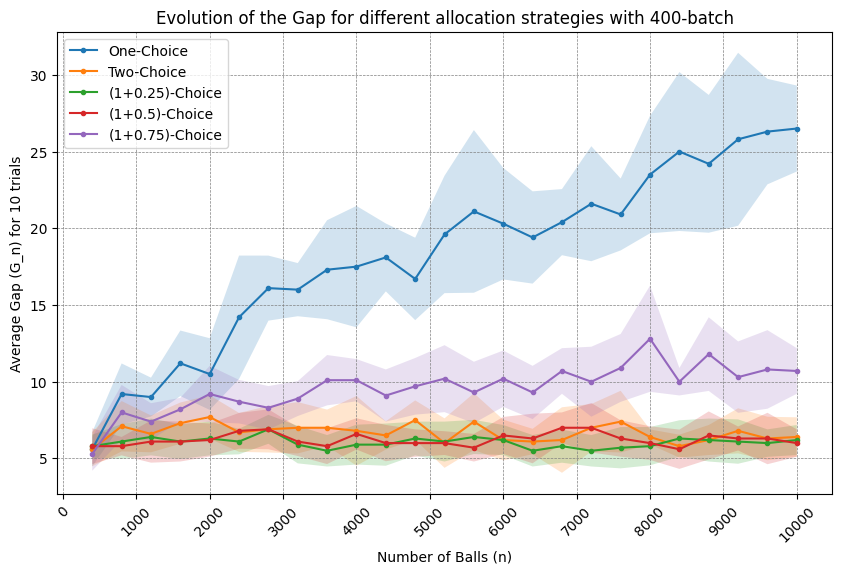

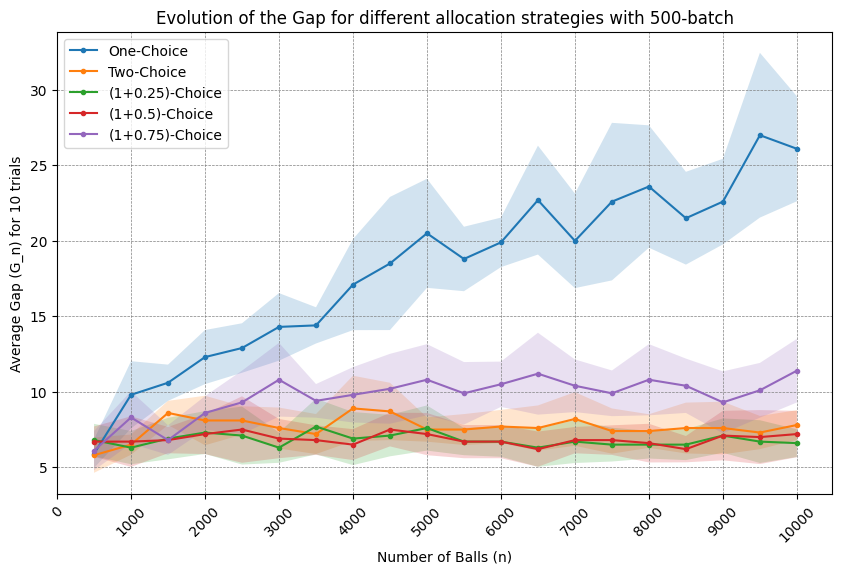

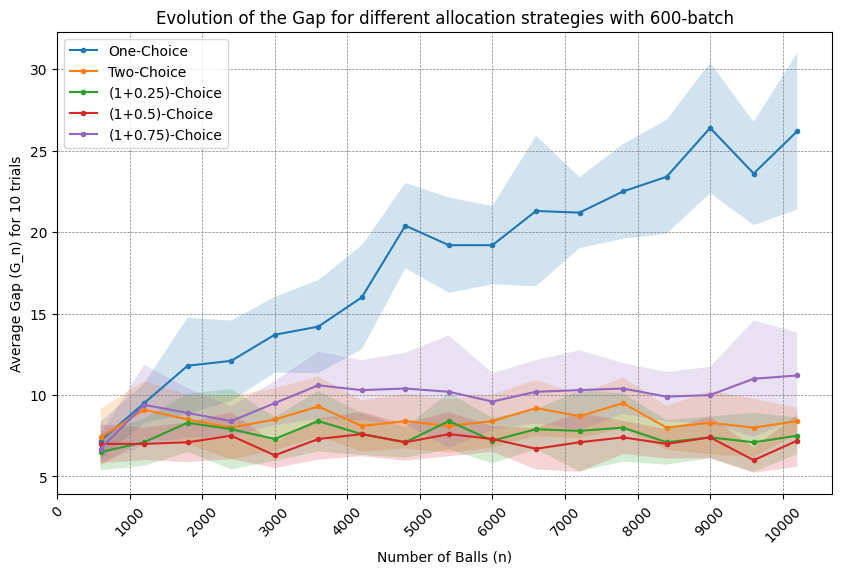

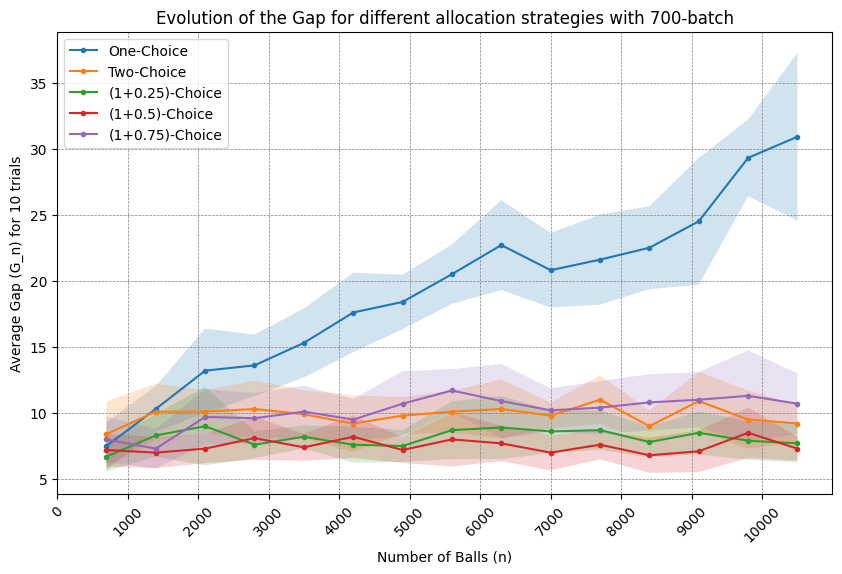

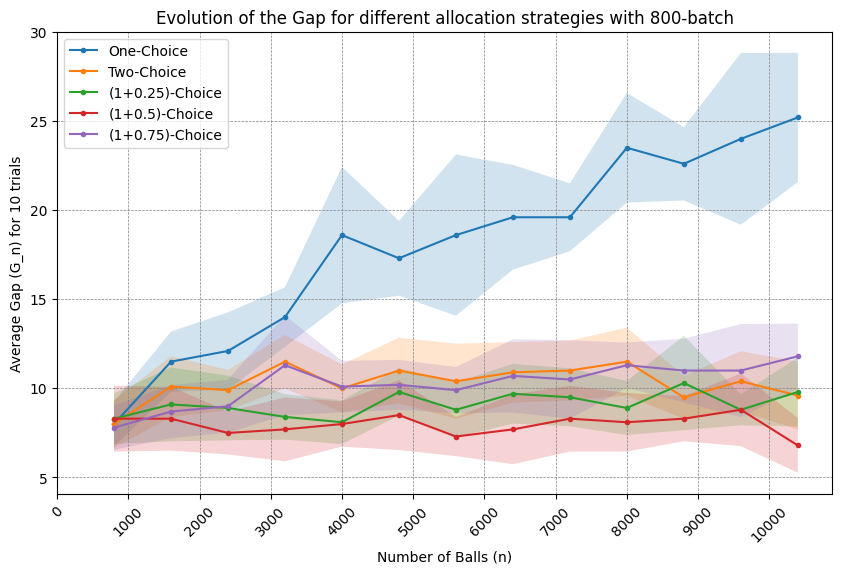

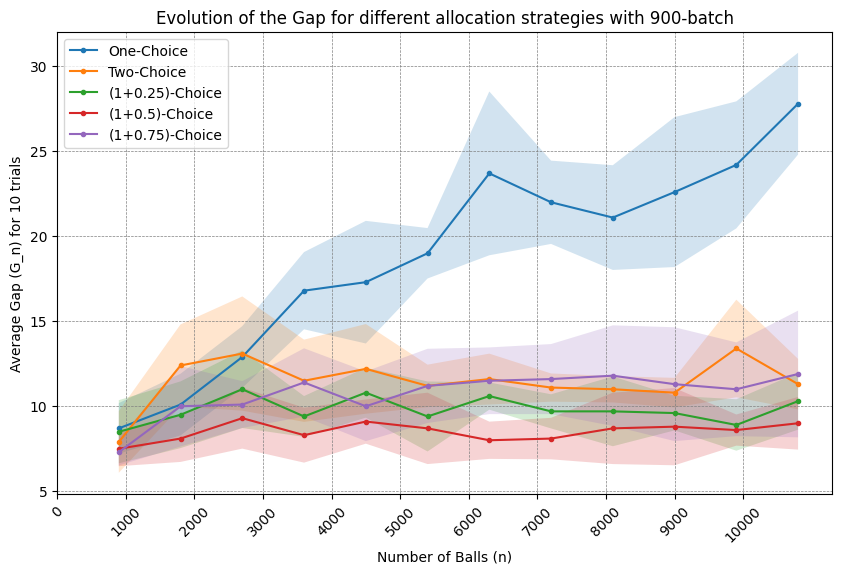

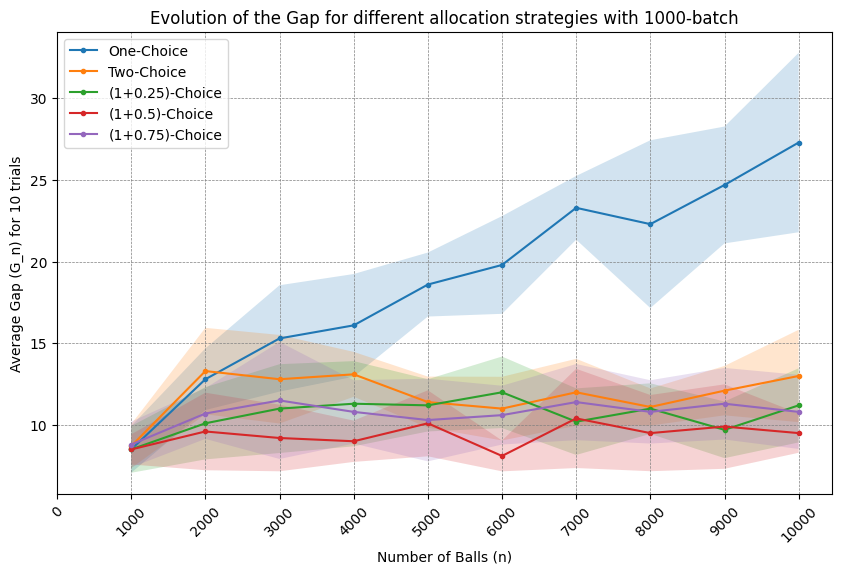

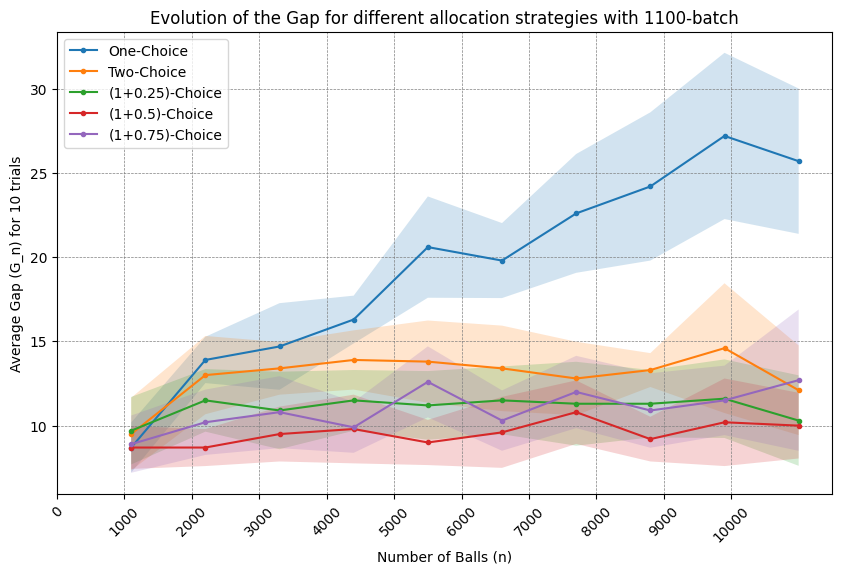

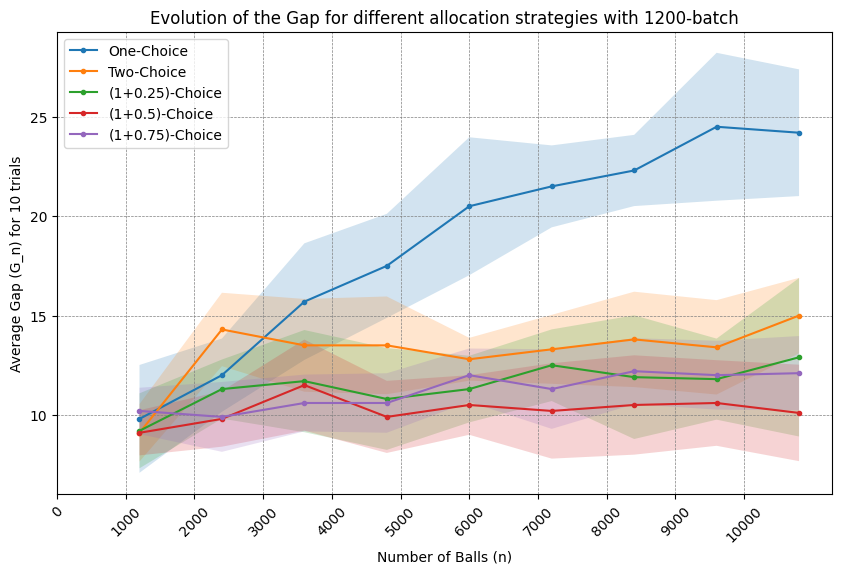

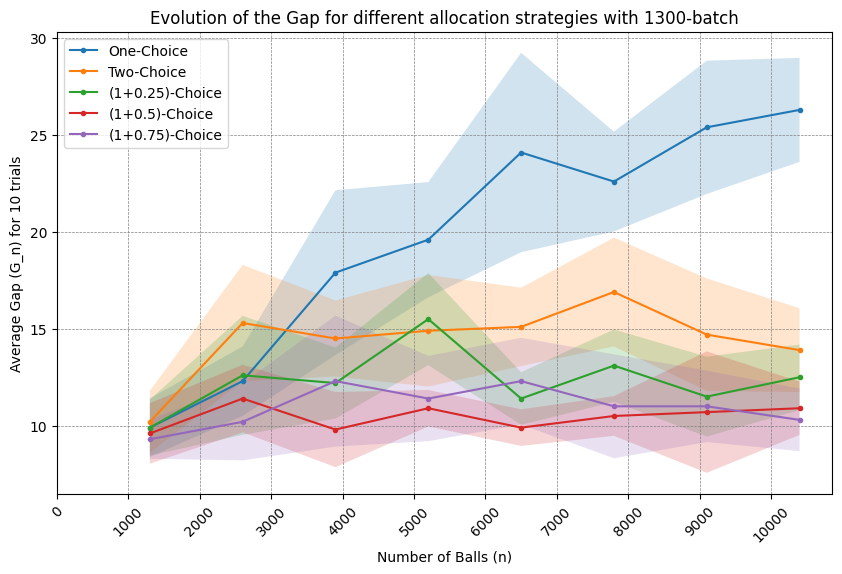

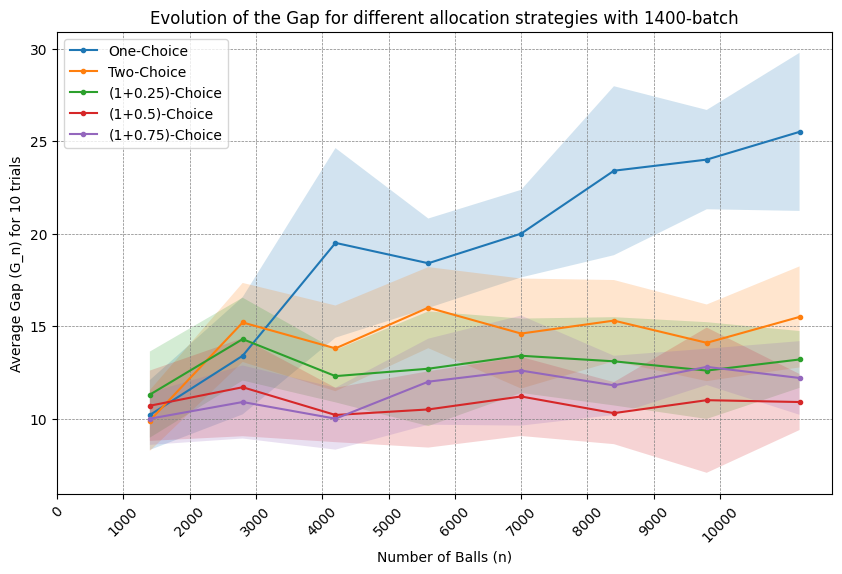

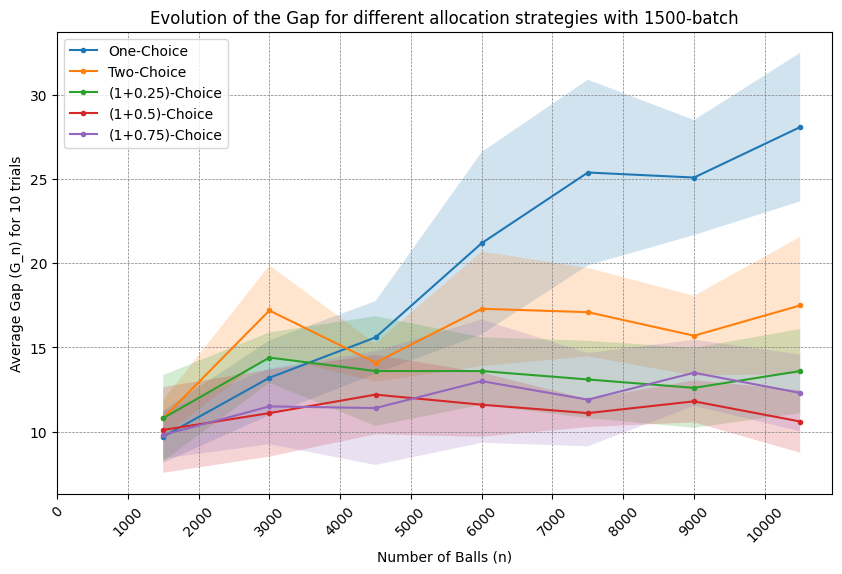

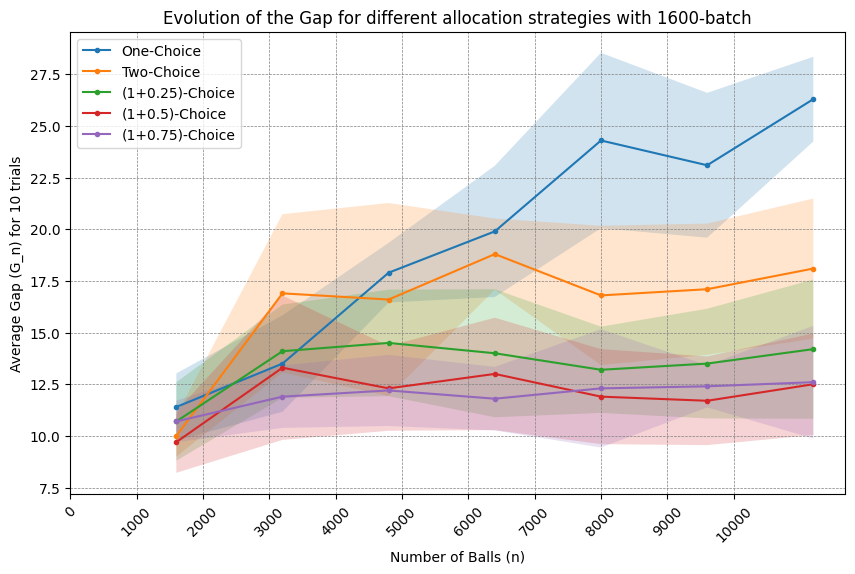

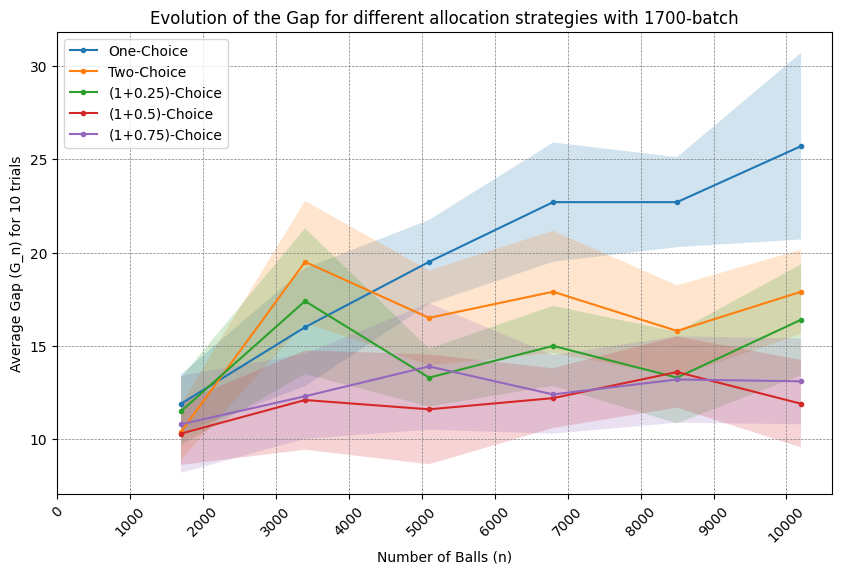

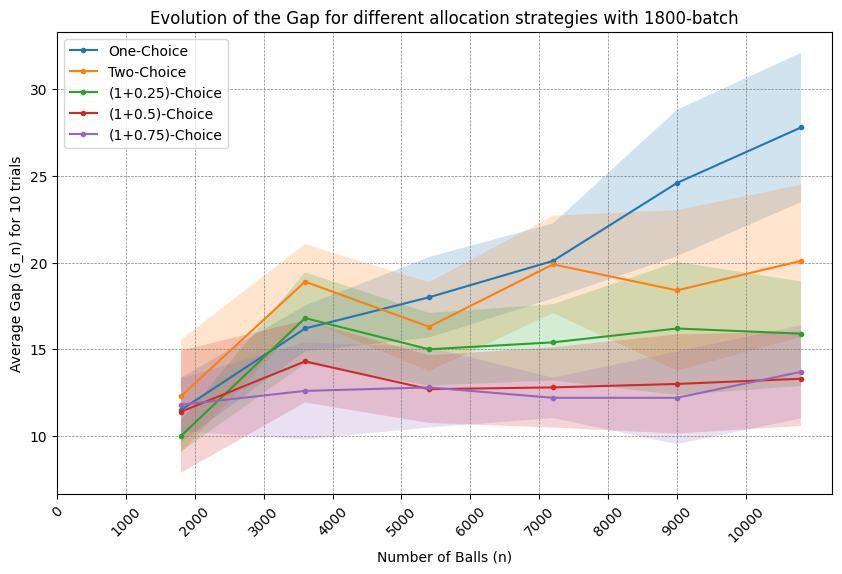

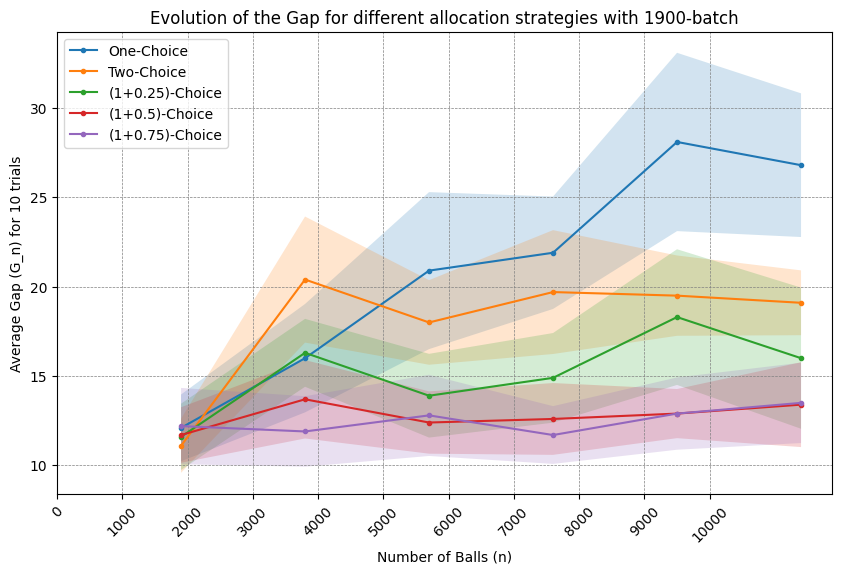

KeyboardInterrupt: 

In [3]:
# Parameters
m = 100  # Number of bins
d_batches = np.arange(m, 20*m, m)

T = 10  # Number of trials for averaging
beta_values = [0.25, 0.5, 0.75]  # Different beta values for (1 + beta)-choice

# Set random seed for reproducibility
np.random.seed(42)

# Run experiments and plot results
for d in d_batches:
    gaps = { "One-Choice": [], "Two-Choice": [] }
    stddevs = { "One-Choice": [], "Two-Choice": [] }
    for beta in beta_values:
        gaps[f"(1+{beta})-Choice"] = []
        stddevs[f"(1+{beta})-Choice"] = []
    n_values=range(d, m**2+d, d)
    for n in n_values:  # Iterate over increasing number of balls in a batch
        gaps_n = { key: [] for key in gaps.keys() }

        for _ in range(T):
            # Initialize bins for each strategy
            bins_one_choice = np.zeros(m, dtype=int)
            bins_two_choice = np.zeros(m, dtype=int)
            bins_beta = { beta: np.zeros(m, dtype=int) for beta in beta_values }
            for _ in range(n//d):
                one_choice(bins_one_choice, d, m)
                two_choice(bins_two_choice, d, m)
                for beta in beta_values:
                    beta_choice(bins_beta[beta], beta, d, m)
            
            # Compute gaps for each strategy
            gaps_n["One-Choice"].append(compute_gap(bins_one_choice, n, m))
            gaps_n["Two-Choice"].append(compute_gap(bins_two_choice, n, m))
            for beta in beta_values:
                gaps_n[f"(1+{beta})-Choice"].append(compute_gap(bins_beta[beta], n, m))
        
        # Store the average gap across trials
        for key in gaps.keys():
            gaps[key].append(np.mean(gaps_n[key]))
            stddevs[key].append(np.std(gaps_n[key]))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    for key, values in gaps.items():
        # Mean and standard deviation for each value of n
        means = values
        stds = stddevs[key]
        
        # Plot mean with shaded area for standard deviation
        plt.plot(n_values, means, marker='.', label=key)
        plt.fill_between(n_values, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)

    step_size = 1000
    plt.xticks(np.arange(0, m**2 + step_size, step_size), rotation=45)
    
    plt.grid(True)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel("Number of Balls (n)")
    plt.ylabel(f"Average Gap (G_n) for {T} trials")
    plt.title(f"Evolution of the Gap for different allocation strategies with {d}-batch")
    plt.legend()
    if SAVE_FIGS:
        plt.savefig(f"different_allocation-{m}_m-{d}_batch.pdf")
    plt.show()

In [34]:
import multiprocessing as mp

# Parameters
m = 100  # Number of bins
d_batches = np.concatenate((np.array([1]), np.arange(m, 20 * m, m)))
T = 10  # Number of trials for averaging
beta_values = [0.25, 0.5, 0.75]  # Different beta values for (1 + beta)-choice

# Set random seed for reproducibility
np.random.seed(42)

# Helper function to process each n in n_values
def process_n(n, d, m, T, beta_values):
    gaps_n = { "One-Choice": [], "Two-Choice": [] }
    for beta in beta_values:
        gaps_n[f"(1+{beta})-Choice"] = []

    # Run T trials for this n
    for _ in range(T):
        bins_one_choice = np.zeros(m, dtype=int)
        bins_two_choice = np.zeros(m, dtype=int)
        bins_beta = {beta: np.zeros(m, dtype=int) for beta in beta_values}

        for _ in range(n // d):
            one_choice(bins_one_choice, d, m)
            two_choice(bins_two_choice, d, m)
            for beta in beta_values:
                beta_choice(bins_beta[beta], beta, d, m)

        # Compute and collect gaps for each strategy
        gaps_n["One-Choice"].append(compute_gap(bins_one_choice, n, m))
        gaps_n["Two-Choice"].append(compute_gap(bins_two_choice, n, m))
        for beta in beta_values:
            gaps_n[f"(1+{beta})-Choice"].append(compute_gap(bins_beta[beta], n, m))

    # Calculate mean and std dev for each strategy
    results = {
        "n": n,
        "means": {key: np.mean(gaps_n[key]) for key in gaps_n},
        "stddevs": {key: np.std(gaps_n[key]) for key in gaps_n}
    }
    return results

# Run experiments and plot results
for d in d_batches:
    n_values = range(d, m**2 + d, d)
    
    # Using multiprocessing to parallelize the n_values loop
    with mp.Pool() as pool:
        results = pool.starmap(process_n, [(n, d, m, T, beta_values) for n in n_values])

    gaps = { "One-Choice": [], "Two-Choice": [] }
    for beta in beta_values:
        gaps[f"(1+{beta})-Choice"] = []
    stddevs = { "One-Choice": [], "Two-Choice": [] }
    for beta in beta_values:
        stddevs[f"(1+{beta})-Choice"] = []
        
    # Collect results from each n
    for result in results:
        for key in result["means"]:
            gaps[key].append(result["means"][key])
            stddevs[key].append(result["stddevs"][key])

    # Plotting
    plt.figure(figsize=(10, 6))
    for key, values in gaps.items():
        means = values
        stds = stddevs[key]
        plt.plot(n_values, means, marker='.', label=key)
        plt.fill_between(n_values, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)

    step_size = 1000
    plt.xticks(np.arange(0, m**2 + step_size, step_size), rotation=45)
    
    plt.grid(True)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel("Number of Balls (n)")
    plt.ylabel(f"Average Gap (G_n) for {T} trials")
    plt.title(f"Evolution of the Gap for different allocation strategies with {d}-batch")
    plt.legend()
    if SAVE_FIGS:
        plt.savefig(f"different_allocation-{m}_m-{d}_batch.pdf")
    plt.show()


KeyboardInterrupt: 

## Gap for partial information strategies considering $d$-batch

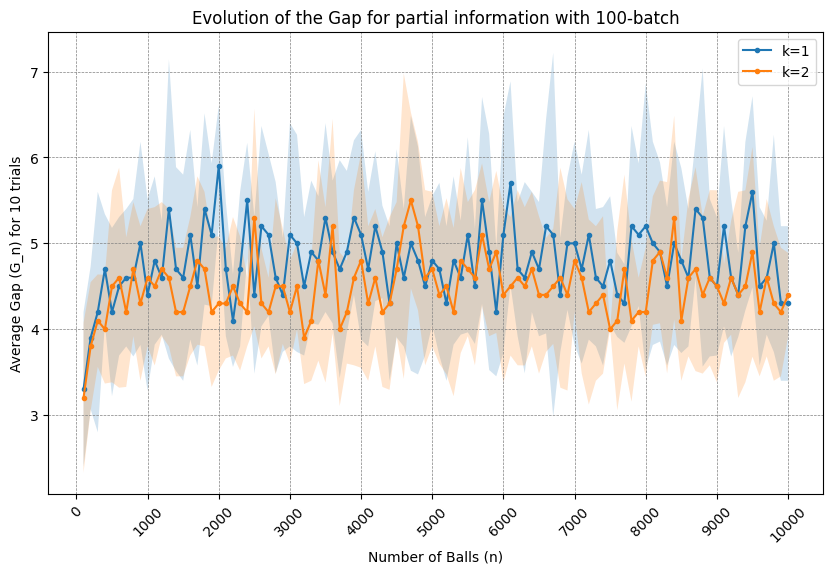

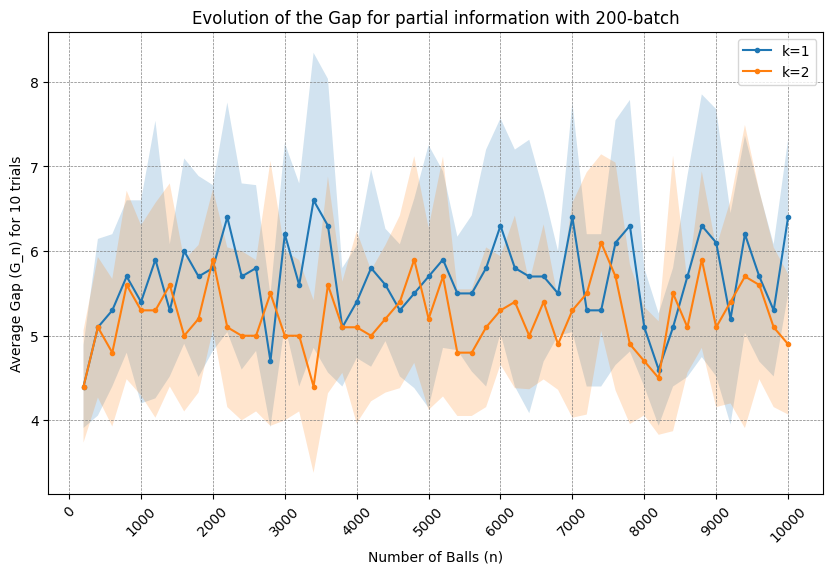

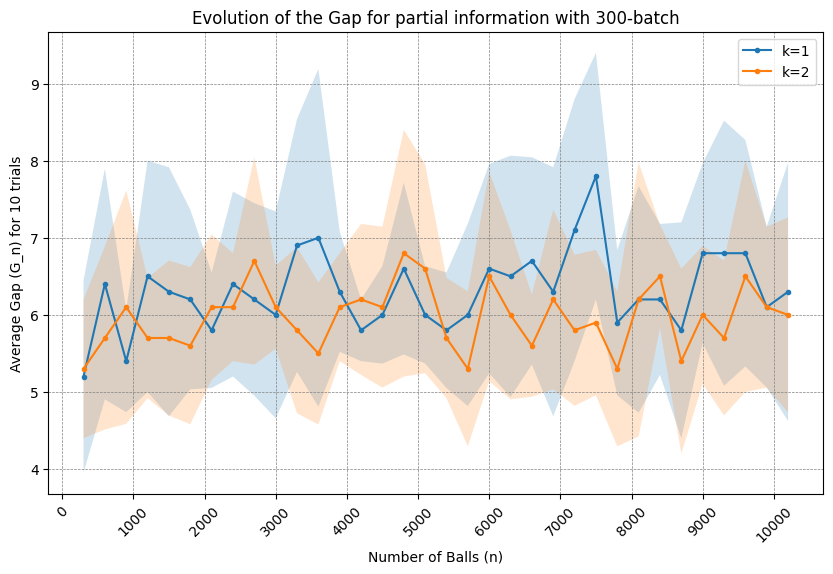

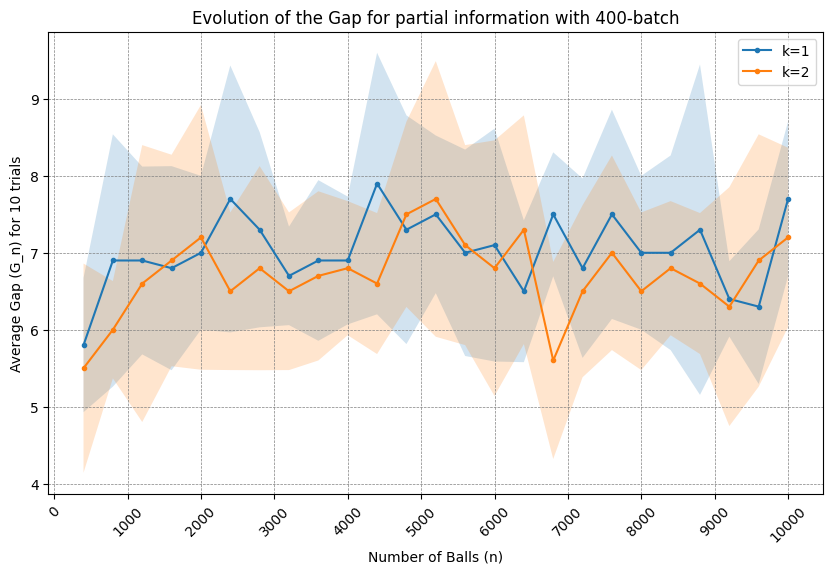

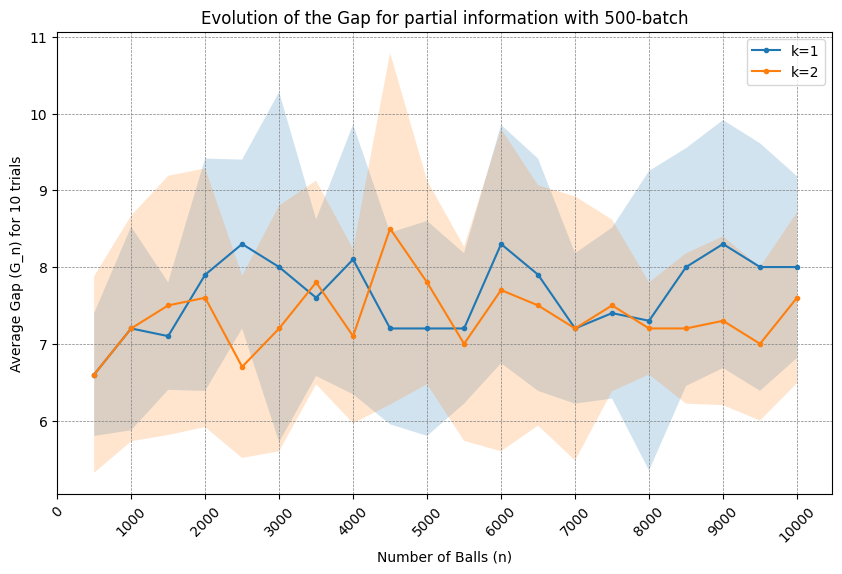

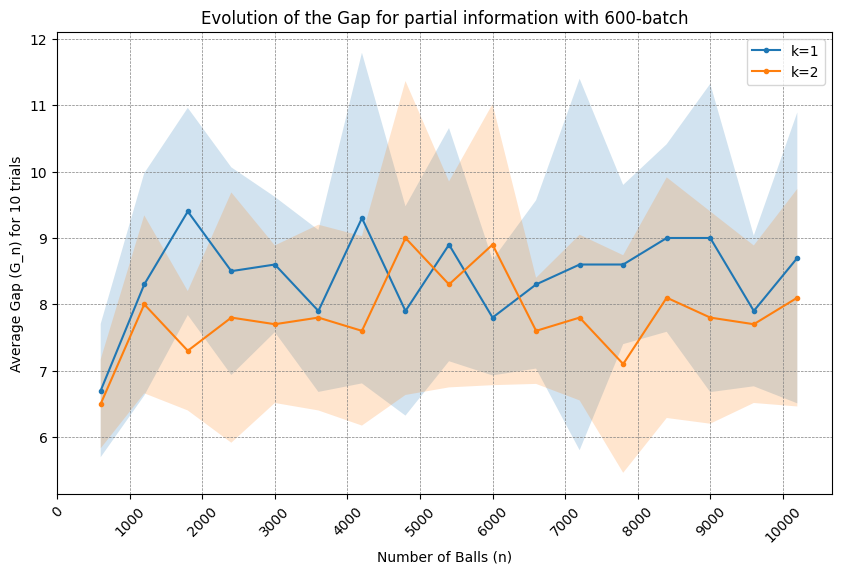

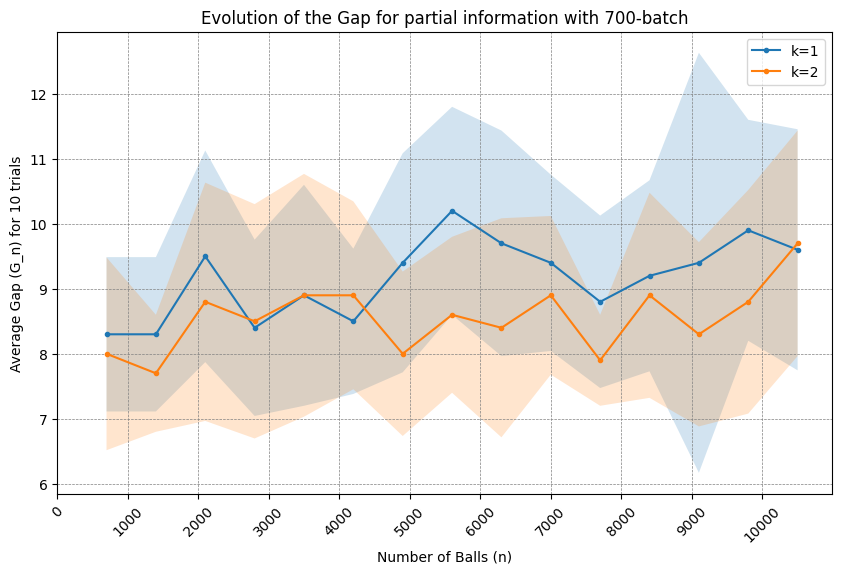

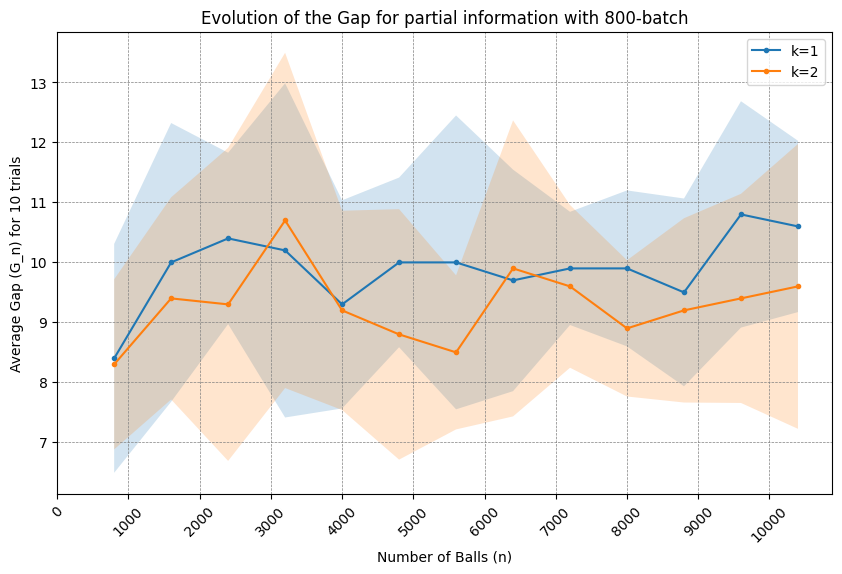

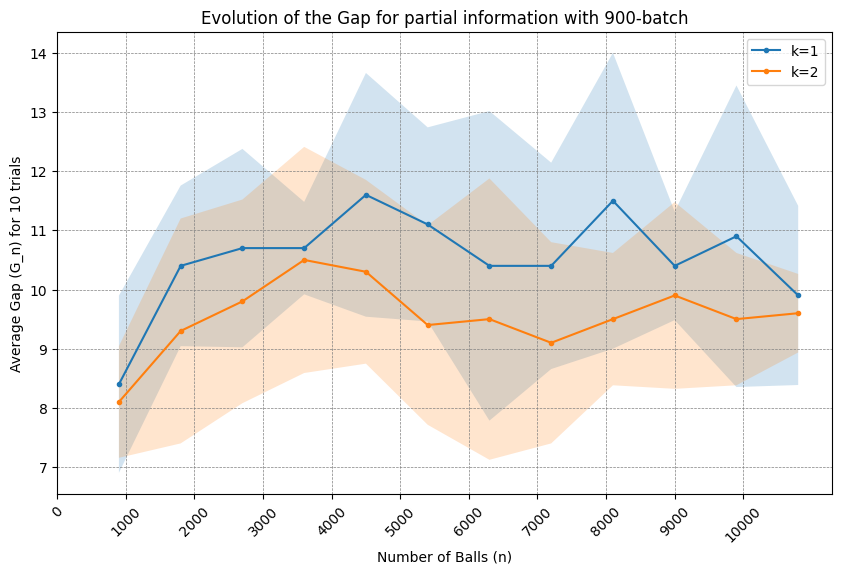

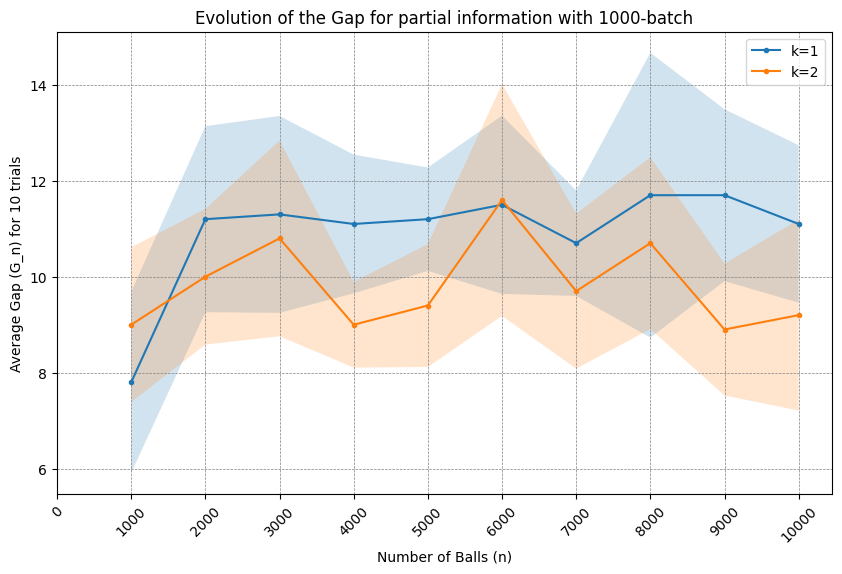

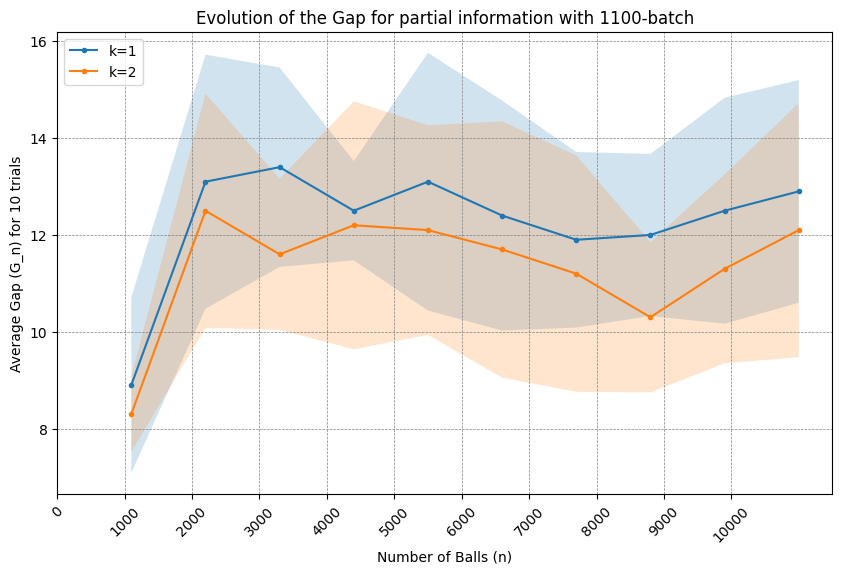

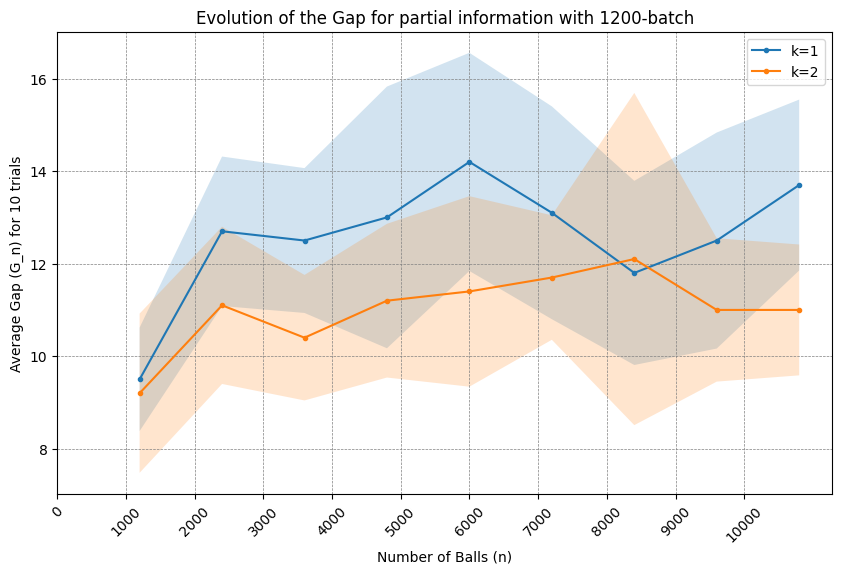

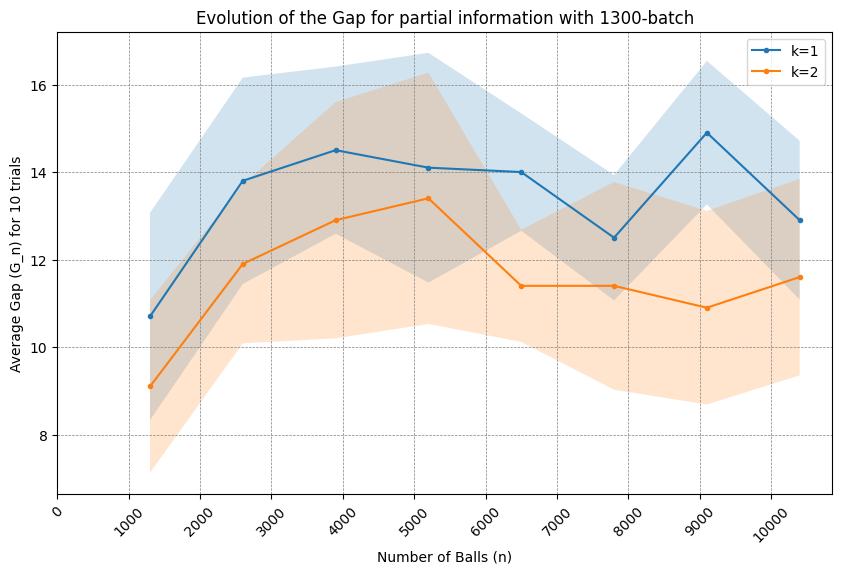

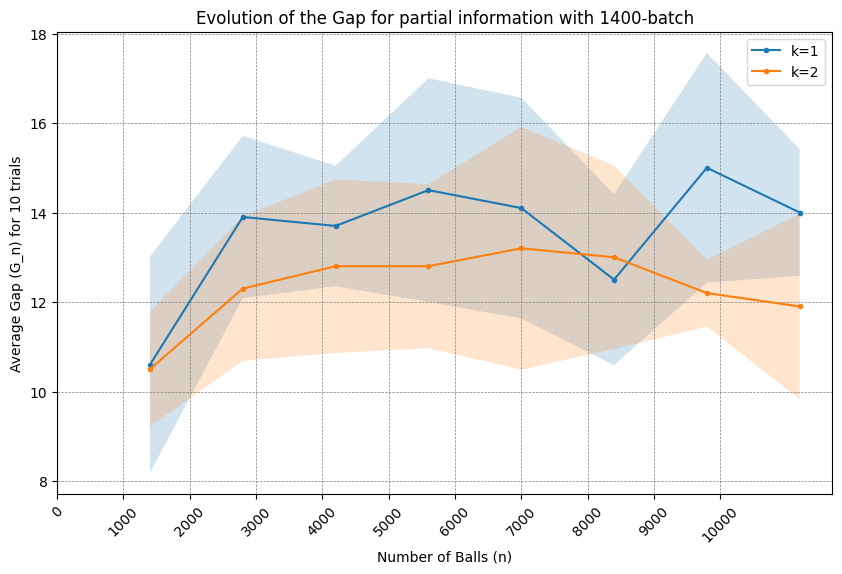

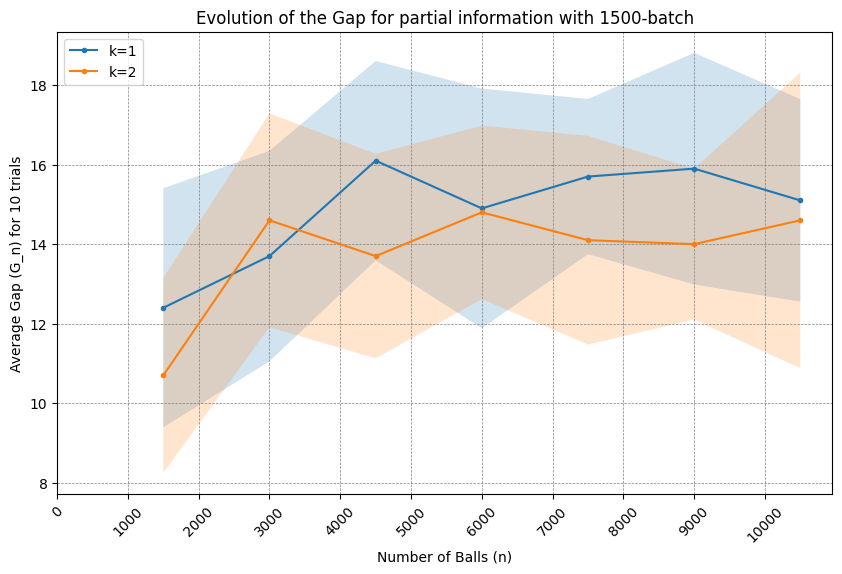

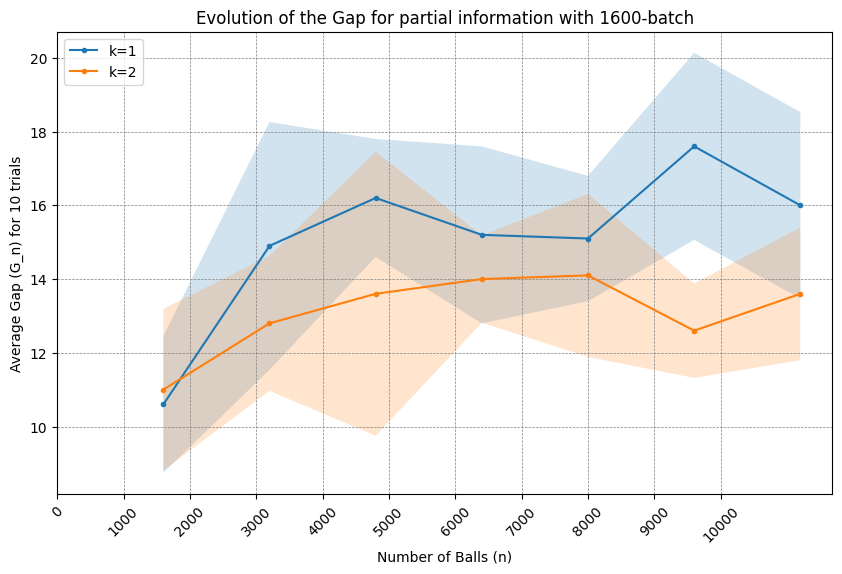

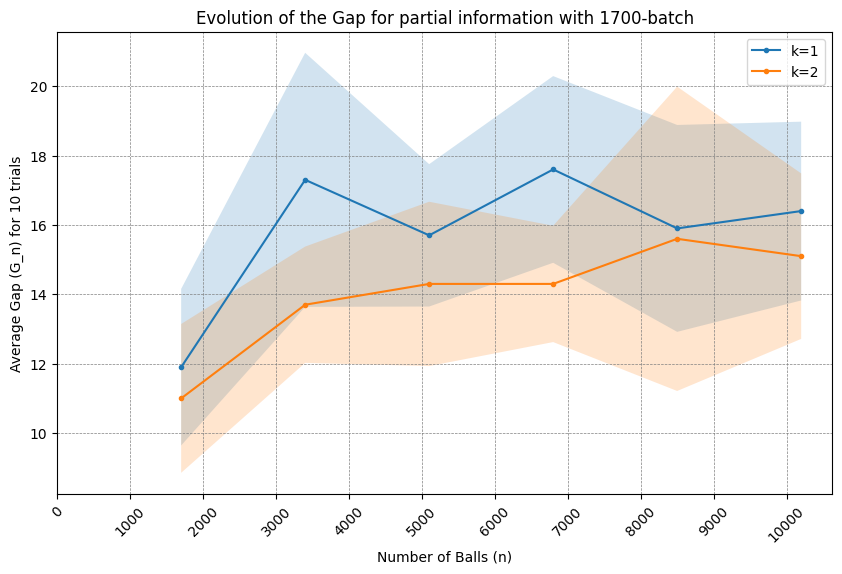

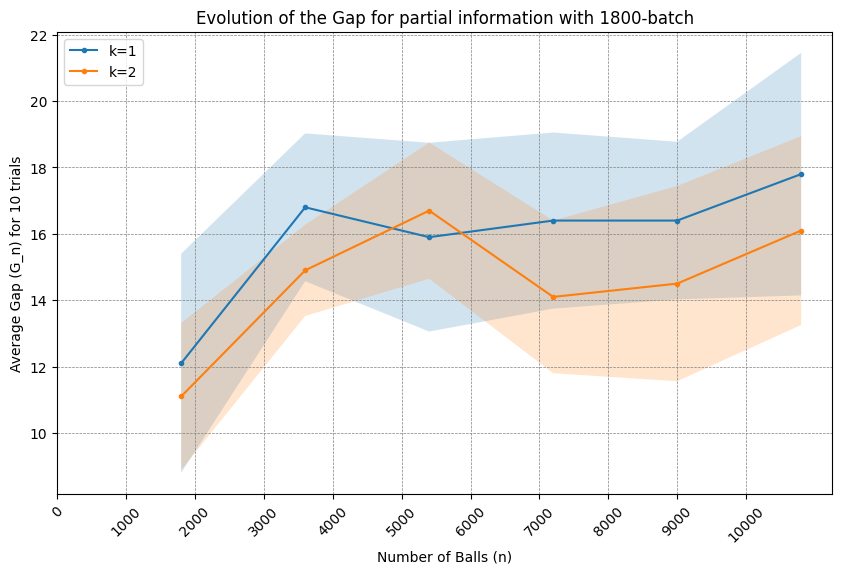

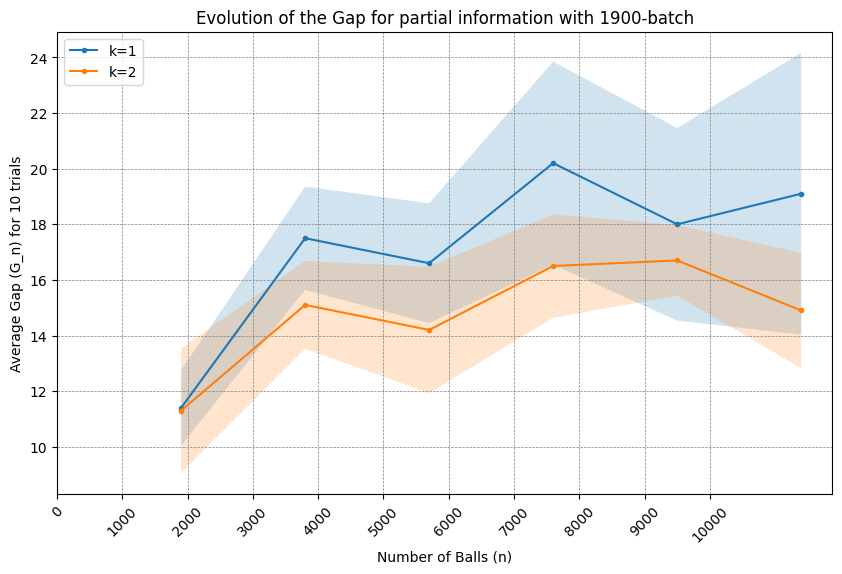

In [12]:
# Parameters
m = 100  # Number of bins
d_batches = range(m, 20*m, m)
T = 10  # Number of trials for averaging

# Set random seed for reproducibility
np.random.seed(42)

# Run experiments and plot results
for d in d_batches:
     # Run experiments and plot results for k=1 and k=2
    gaps_k1 = []
    gaps_k2 = []
    stddevs_k1 = []
    stddevs_k2 = []
        
    n_values=range(d, m**2+d, d)
    for n in n_values:  # Iterate over increasing number of balls in a batch
        gaps_n_k1 = []
        gaps_n_k2 = []
        
        for _ in range(T):
            bins_k1 = np.zeros(m, dtype=int)
            bins_k2 = np.zeros(m, dtype=int)

            for _ in range(n//d):
                partial_information_k1(bins_k1, d, m)
                partial_information_k2(bins_k2, d, m)
            
            # Compute gaps for each strategy
            gaps_n_k1.append(compute_gap(bins_k1, n, m))
            gaps_n_k2.append(compute_gap(bins_k2, n, m))
        
        # Store the mean and standard deviation across trials# Random choice if both are the same
        gaps_k1.append(np.mean(gaps_n_k1))
        stddevs_k1.append(np.std(gaps_n_k1))
        gaps_k2.append(np.mean(gaps_n_k2))
        stddevs_k2.append(np.std(gaps_n_k2))
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, gaps_k1, marker='.', label="k=1")
    plt.fill_between(n_values, np.array(gaps_k1) - np.array(stddevs_k1), 
                     np.array(gaps_k1) + np.array(stddevs_k1), alpha=0.2)
    
    plt.plot(n_values, gaps_k2, marker='.', label="k=2")
    plt.fill_between(n_values, np.array(gaps_k2) - np.array(stddevs_k2), 
                     np.array(gaps_k2) + np.array(stddevs_k2), alpha=0.2)
    step_size = 1000
    plt.xticks(np.arange(0, m**2 + step_size, step_size), rotation=45)

    plt.grid(True)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel("Number of Balls (n)")
    plt.ylabel(f"Average Gap (G_n) for {T} trials")
    plt.title(f"Evolution of the Gap for partial information with {d}-batch")
    plt.legend()
    if SAVE_FIGS:
        plt.savefig(f"partial_information-{m}_m-{d}_batch.pdf")
    plt.show()